In [2]:
import pandas as pd
import random

from functools import partial
import math
import os
import tqdm
import numpy as np
#import bamboolib as bam
import sklearn
from matplotlib import pyplot 
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot as plt
    
from kneed import KneeLocator
import scipy



#bam.__version__

# Detecting periods and ruptures

In [116]:
index_file_JP="indexation_results/index_alldefault_nameexhaustive_aymeric.csv"
index_file=index_file_JP


In [117]:
df=pd.read_csv(index_file, sep='\t')



In [118]:
len(df)

7940777

In [119]:
df.term.value_counts()

pesticides               1161502
glyphosate                537734
santé                     182225
culture                   152662
monsanto                  140382
                          ...   
m. orphelin                   48
soja transgéniques            45
syndrome prémenstruel         36
agriconomie                   31
hypothyroïdie                 29
Name: term, Length: 453, dtype: int64

In [120]:
df.head(10)

,term,doc_id,sent_id,origin,source,date
0,agriculteur,1128193072427409409,0,twitter,cchris,2019-05-14
1,pesticides,1128193072427409409,0,twitter,cchris,2019-05-14
2,travail,1128193072427409409,0,twitter,cchris,2019-05-14
3,pesticides,1176045364522209280,0,twitter,clamart-citoyenne,2019-09-23
4,écologique,1176045364522209280,1,twitter,clamart-citoyenne,2019-09-23
5,développement,211801,0,facebook,Groupe Beneteau,2019-04-26
6,travail,211801,0,facebook,Groupe Beneteau,2019-04-26
7,campagne,211801,0,facebook,Groupe Beneteau,2019-04-26
8,pesticides,211801,0,facebook,Groupe Beneteau,2019-04-26
9,urine,211801,0,facebook,Groupe Beneteau,2019-04-26


In [121]:
len(df)

7940777

In [122]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['yearmonth']=(df['date'].dt.strftime('%Y-%m'))
df=df[~df['yearmonth'].isin(['2008-04', '2010-01','2021-02'])]

In [123]:
df=df.dropna(subset=['yearmonth'])
len(df)

7832372

In [124]:
len(df)

7832372

In [184]:
df_term_freq_0=pd.DataFrame()
for target in ["source",'term']:
    N=500
    topN=df[target].value_counts().index[:N]
    df=df[df[target].isin(topN)]

    df_term_freq = df.groupby(['origin','yearmonth', target])['doc_id'].count().reset_index()
    df_term_freq
    


    df_term_df = df.groupby(['origin',target])['doc_id'].nunique().reset_index()
    df_term_df
    df_term_B = df.groupby(['origin'])['doc_id'].nunique().reset_index()
    df_term_B
    df_term_df=df_term_df.merge(df_term_B,on='origin')

    

    df_term_df['idf']=np.log(df_term_df['doc_id_y']/df_term_df['doc_id_x'])#*np.log(df_term_df['doc_id_y']/df_term_df['doc_id_x'])*np.log(df_term_df['doc_id_y']/df_term_df['doc_id_x'])*np.log(df_term_df['doc_id_y']/df_term_df['doc_id_x'])
    df_term_df

    df_term_freq=df_term_freq.merge(df_term_df[[target,'idf']],on=target)
    df_term_freq
    df_term_freq['score']=df_term_freq['doc_id']*df_term_freq['idf']
    df_term_freq['target']=df_term_freq[target]
    df_term_freq_0=pd.concat([df_term_freq_0,df_term_freq])

df_term_freq=df_term_freq_0.reset_index(drop=True)



In [129]:
#df_term_freq.doc_id.sum()

10579398

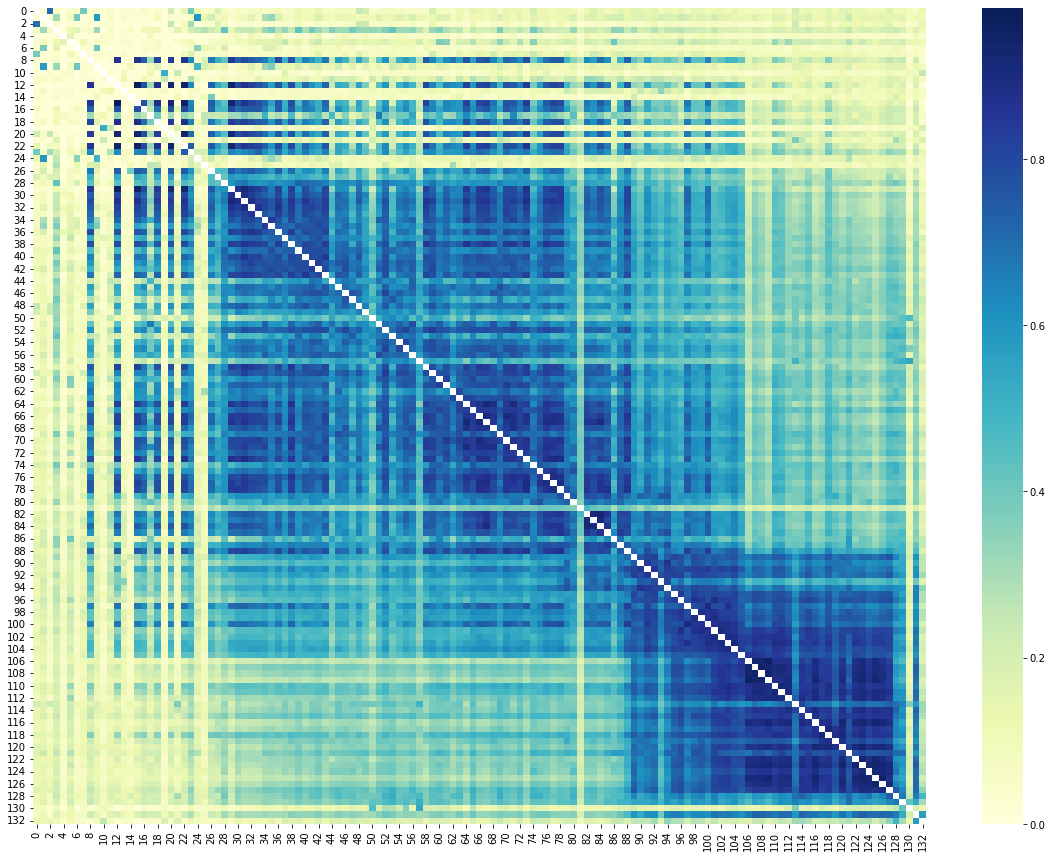

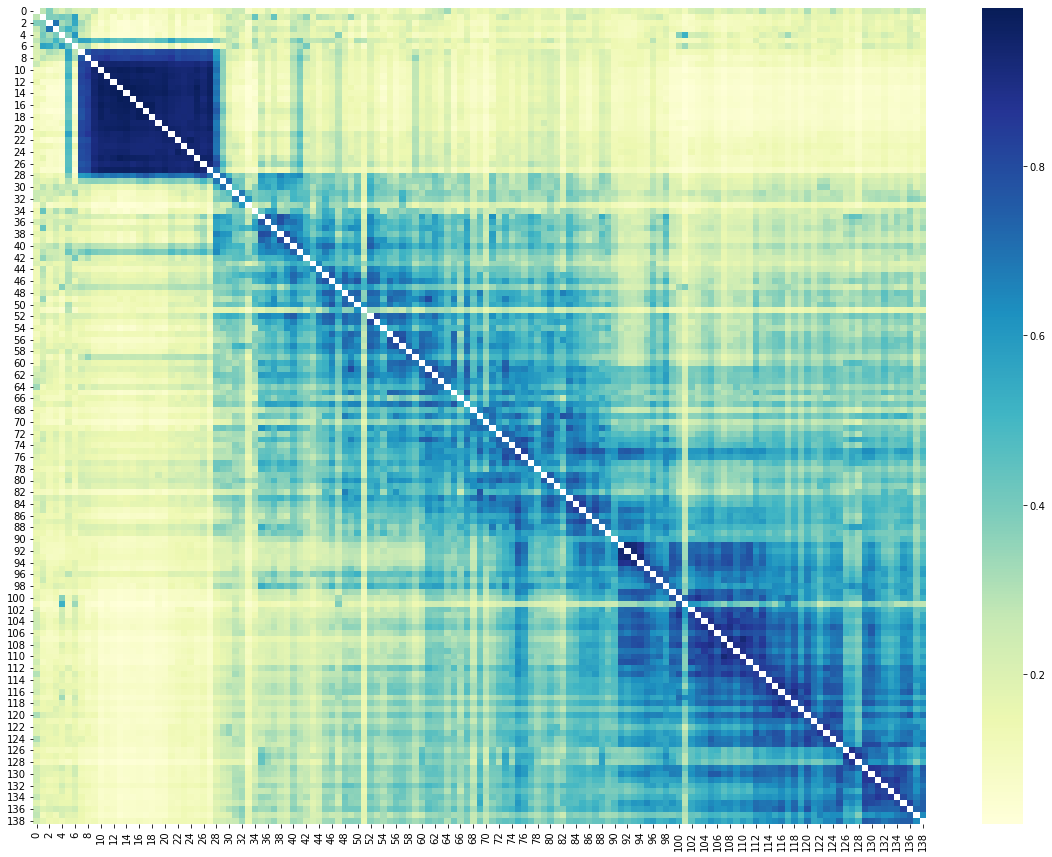

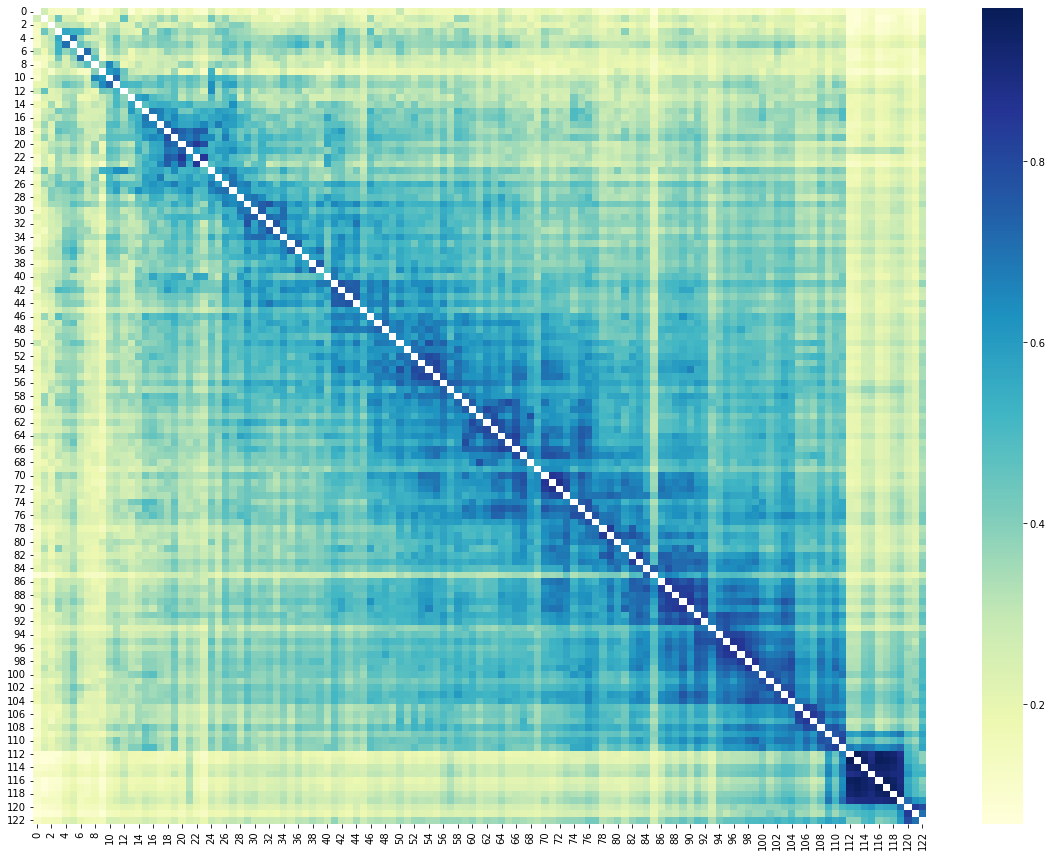

In [12]:
ms={}

for origin0 in ['media','twitter','facebook']:
    table = pd.pivot_table(df_term_freq[df_term_freq["origin"]==origin0], values='score', index=['yearmonth'],columns=["target"], aggfunc=np.sum)

    table.fillna(0,inplace=True)
    m=scipy.sparse.csc_matrix(table.values)
    ms[origin0]=m
    dist=metrics.pairwise.cosine_similarity(m)
    for  i in range(len(dist)):
        dist[i,i]=np.nan
    fig, ax = pyplot.subplots(figsize=(20,15))
    sns.heatmap(dist,cmap="YlGnBu",ax=ax)#,vmin=0,vmax=1)
    plt.savefig(origin0+'_with_'+target+'.pdf')





# Ruptures

In [13]:
import ruptures as rpt  # our package
from ruptures.base import BaseCost
from sklearn.metrics.pairwise import cosine_similarity

class CosineCost(BaseCost):
    """Cost derived from the cosine similarity."""

    # The 2 following attributes must be specified for compatibility.
    model = "custom_cosine"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        self.gram = cosine_similarity(signal, dense_output=False)
        return self

    def error(self, start, end) -> float:
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment
        Returns:
            segment cost
        Raises:
            NotEnoughPoints: when the segment is too short (less than `min_size` samples).
        """
        if end - start < self.min_size:
            raise NotEnoughPoints
        sub_gram = self.gram[start:end, start:end]
        val = sub_gram.diagonal().sum()
        val -= sub_gram.sum() / (end - start)
        return val
    
#computing high level distance between blocks
def build_hl(m,dico_segment):
    dist_hl={}
    for i in range(m.shape[0]):
        #print(i)
        vec0=[]
        segi=dico_segment[i]
        if not segi in dist_hl:
            dist_hl[segi]={}
        for j in range(m.shape[0]):

            segj=dico_segment[j]
            #print(j,segj)
            if segi==segj:
                if i!=j:
                    dist_hl[segi][segj]=dist_hl[segi].get(segj,0)+dist[i,j] /(len(dico_segment_inv[segi])-1)/len(dico_segment_inv[segj])
            else:
                dist_hl[segi][segj]=dist_hl[segi].get(segj,0)+dist[i,j] /(len(dico_segment_inv[segi]))/len(dico_segment_inv[segj])
    dist_sym=[]
    for i in range(m.shape[0]):
        vec0=[]
        for j in range(m.shape[0]):
            if i>j:
                vec0.append(dist[i,j])
            elif i==j:
                vec0.append(np.nan)
            else:
                vec0.append(dist_hl[dico_segment[i]][dico_segment[j]])
        dist_sym.append(vec0)
    return dist_sym
#dist_sym



In [14]:
time_segms={}
for origin in ms:
    m=ms[origin]
    costs=[]
    predicted_bkpslist=[]
    for n_bkps in range(0, 50, 1):
        #print(n_bkps)
        algo = rpt.Dynp(custom_cost=CosineCost(), min_size=1, jump=1).fit(m)
        predicted_bkps = algo.predict(n_bkps=n_bkps)
        sumcost=algo.cost.sum_of_costs(predicted_bkps)
        costs.append([n_bkps, sumcost ])
        predicted_bkpslist.append([predicted_bkps])
    time_segm=pd.DataFrame(predicted_bkps)
    dfcost=pd.DataFrame(costs)
    dfcost.columns = ['nbseg', 'cost']

    x=dfcost['nbseg'].values
    y=dfcost['cost'].values
    kn = KneeLocator(x, y, curve='convex', direction='decreasing')
    nb_segm_optimal=kn.knee
    


    predicted_bkps=predicted_bkpslist[nb_segm_optimal]
    time_segm=pd.DataFrame(predicted_bkps).T
    time_segm.columns = [str(column) for column in time_segm.columns]
    time_segms[origin]=time_segm.values
    print(origin,nb_segm_optimal ," splits: ",list(time_segm.values))

media 11  splits:  [array([4]), array([6]), array([10]), array([12]), array([24]), array([26]), array([44]), array([58]), array([89]), array([105]), array([128]), array([133])]
twitter 7  splits:  [array([7]), array([29]), array([46]), array([68]), array([91]), array([112]), array([126]), array([139])]
facebook 12  splits:  [array([3]), array([8]), array([13]), array([28]), array([40]), array([49]), array([59]), array([78]), array([91]), array([105]), array([112]), array([120]), array([123])]


In [15]:
monthss={}
for origin in ms:

    
    dfo=df[df['origin']==origin].sort_values(by='date')
    months=list(dfo.yearmonth.unique())
    #months.sort()
    monthss[origin]=list(months)

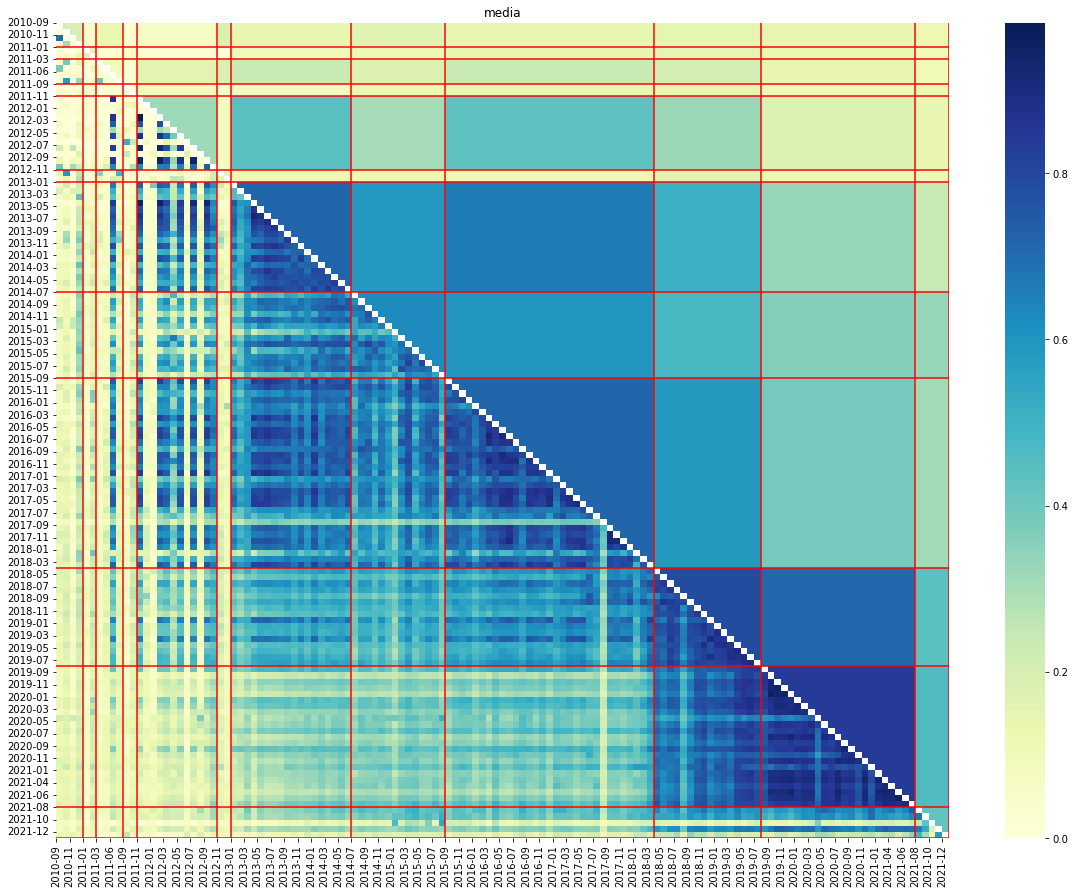

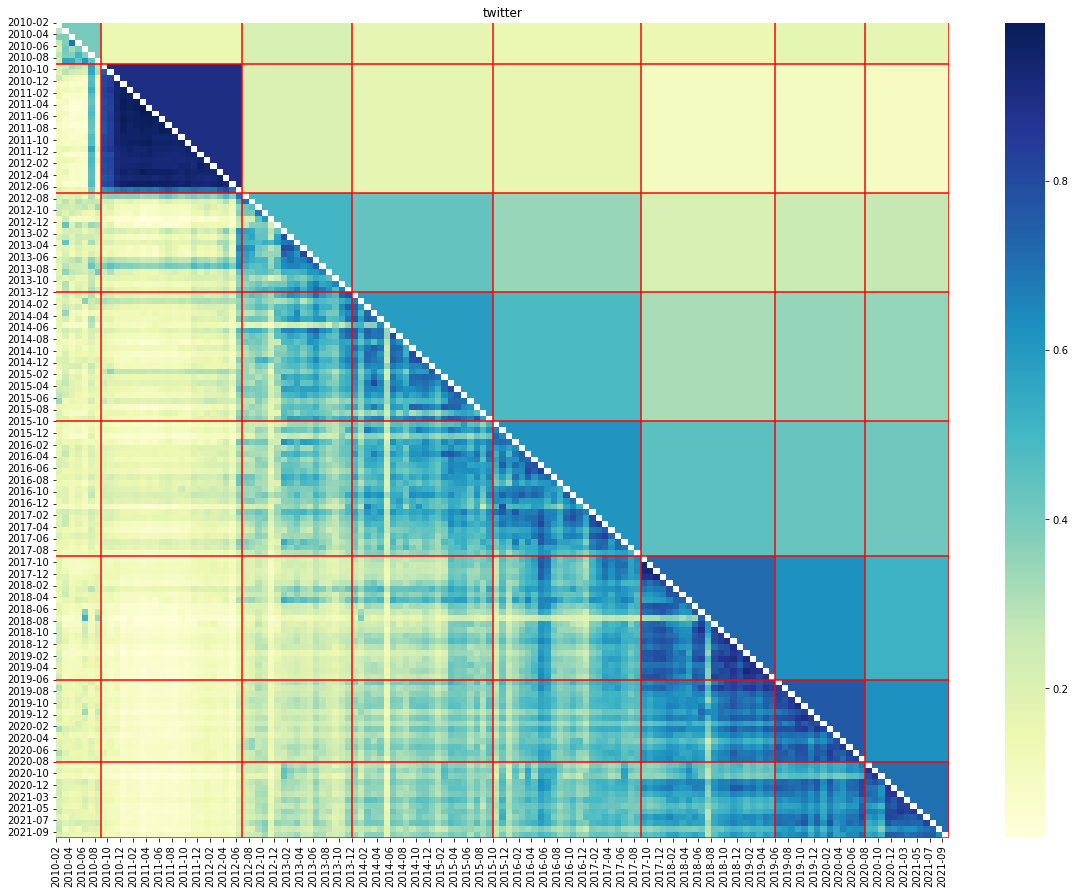

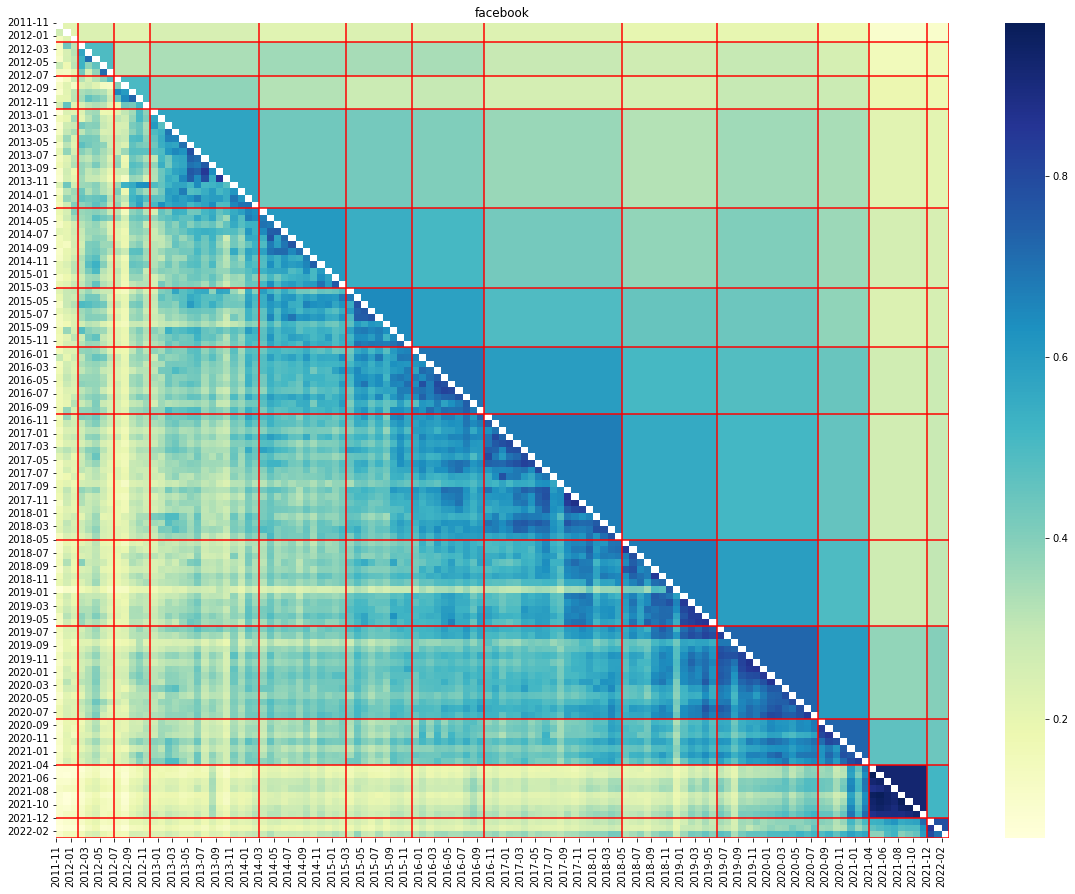

In [16]:

for origin in ms:
    m=ms[origin]
    time_segm=time_segms[origin]
    dist=metrics.pairwise.cosine_similarity(m)

    for i in range(len(dist)):
        dist[i,i]=np.nan

    dico_segment,dico_segment_inv={},{}
    i0,segm_nb=0,0
    for x in time_segm:
        for i in list(range(i0, x[0])):
            dico_segment[i]=segm_nb
            dico_segment_inv.setdefault(segm_nb,[]).append(i)
        segm_nb+=1
        i0=x[0]



    fig, ax = pyplot.subplots(figsize=(20,15))
    dist_sym=build_hl(dist,dico_segment)
    sns.heatmap(dist_sym,cmap="YlGnBu",ax=ax)#,vmin=0,vmax=1)
    #sns.heatmap(dist,cmap="YlGnBu",ax=ax)#,vmin=0,vmax=1)
    for x in time_segm:
        ax.axvline(x[0],color='red')
        ax.axhline(x[0],color='red')
    plt.title(origin)
    step=2
    plt.xticks(range(0,len(monthss[origin]),2),map(lambda x: monthss[origin][x],range(0,len(monthss[origin]),2)))
    plt.yticks(range(0,len(monthss[origin]),2),map(lambda x: monthss[origin][x],range(0,len(monthss[origin]),2)))

    #plt.xlabel(range(len(months)),months,rotate=90)
    plt.savefig(origin+'.pdf')




# #6. find specific terms & actors for detected periods

In [273]:
dico_ts={}
for origin in monthss:
    dico_ts[origin]={}
    for i,x in enumerate((list(map(lambda x: monthss[origin][x],range(0,len(monthss[origin]),1))))):
        dico_ts[origin][x]=int(i)
df_term_freq['ts_media']=df_term_freq['yearmonth'].map(dico_ts["media"])
df_term_freq['ts_facebook']=df_term_freq['yearmonth'].map(dico_ts["facebook"])
df_term_freq['ts_twitter']=df_term_freq['yearmonth'].map(dico_ts["twitter"])



dico_ps={}
for origin in time_segms:
    dico_ps[origin]={}
    i0=0
    for segm_i,x in enumerate(time_segms[origin]):
        for i in list(range(i0, x[0])):
            dico_ps[origin][i]=segm_i
        i0=x[0]
            
df_term_freq['P_media']=df_term_freq['ts_media'].map(dico_ps["media"])
df_term_freq['P_facebook']=df_term_freq['ts_facebook'].map(dico_ps["facebook"])
df_term_freq['P_twitter']=df_term_freq['ts_twitter'].map(dico_ps["twitter"])




In [274]:
df_term_freq['P']=0
dico=pd.concat([df_term_freq[df_term_freq["origin"]=='twitter']['P_twitter'],df_term_freq[df_term_freq["origin"]=='facebook']['P_facebook'],df_term_freq[df_term_freq["origin"]=='media']['P_media']]).to_dict()


In [275]:
df_term_freq

,origin,yearmonth,source,doc_id,idf,score,target,term,ts_media,ts_facebook,ts_twitter,P_media,P_facebook,P_twitter,P
0,facebook,2011-11,ASSAUPAMAR,4,6.229836,24.919343,ASSAUPAMAR,NaN,12.0,0.0,21.0,4.0,0.0,1.0,0
1,facebook,2011-11,ASSAUPAMAR,4,10.704599,42.818397,ASSAUPAMAR,NaN,12.0,0.0,21.0,4.0,0.0,1.0,0
2,facebook,2011-12,ASSAUPAMAR,23,6.229836,143.286224,ASSAUPAMAR,NaN,13.0,1.0,22.0,4.0,0.0,1.0,0
3,facebook,2011-12,ASSAUPAMAR,23,10.704599,246.205785,ASSAUPAMAR,NaN,13.0,1.0,22.0,4.0,0.0,1.0,0
4,facebook,2012-02,ASSAUPAMAR,5,6.229836,31.149179,ASSAUPAMAR,NaN,15.0,3.0,24.0,4.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256441,twitter,2019-12,NaN,1,7.535521,7.535521,punaises diaboliques,punaises diaboliques,109.0,97.0,118.0,10.0,9.0,6.0,0
256442,twitter,2019-12,NaN,1,11.803212,11.803212,punaises diaboliques,punaises diaboliques,109.0,97.0,118.0,10.0,9.0,6.0,0
256443,media,2019-04,NaN,1,9.381348,9.381348,syndrome prémenstruel,syndrome prémenstruel,101.0,89.0,110.0,9.0,8.0,5.0,0
256444,media,2020-03,NaN,2,9.381348,18.762696,syndrome prémenstruel,syndrome prémenstruel,112.0,100.0,121.0,10.0,9.0,6.0,0


In [291]:
df_term_freq['P']=df_term_freq.index.map(dico)


In [292]:
df_term_freq

,origin,yearmonth,source,doc_id,idf,score,target,term,ts_media,ts_facebook,ts_twitter,P_media,P_facebook,P_twitter,P
0,facebook,2011-11,ASSAUPAMAR,4,6.229836,24.919343,ASSAUPAMAR,NaN,12.0,0.0,21.0,4.0,0.0,1.0,0.0
1,facebook,2011-11,ASSAUPAMAR,4,10.704599,42.818397,ASSAUPAMAR,NaN,12.0,0.0,21.0,4.0,0.0,1.0,0.0
2,facebook,2011-12,ASSAUPAMAR,23,6.229836,143.286224,ASSAUPAMAR,NaN,13.0,1.0,22.0,4.0,0.0,1.0,0.0
3,facebook,2011-12,ASSAUPAMAR,23,10.704599,246.205785,ASSAUPAMAR,NaN,13.0,1.0,22.0,4.0,0.0,1.0,0.0
4,facebook,2012-02,ASSAUPAMAR,5,6.229836,31.149179,ASSAUPAMAR,NaN,15.0,3.0,24.0,4.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256441,twitter,2019-12,NaN,1,7.535521,7.535521,punaises diaboliques,punaises diaboliques,109.0,97.0,118.0,10.0,9.0,6.0,6.0
256442,twitter,2019-12,NaN,1,11.803212,11.803212,punaises diaboliques,punaises diaboliques,109.0,97.0,118.0,10.0,9.0,6.0,6.0
256443,media,2019-04,NaN,1,9.381348,9.381348,syndrome prémenstruel,syndrome prémenstruel,101.0,89.0,110.0,9.0,8.0,5.0,9.0
256444,media,2020-03,NaN,2,9.381348,18.762696,syndrome prémenstruel,syndrome prémenstruel,112.0,100.0,121.0,10.0,9.0,6.0,10.0


In [333]:
df_final = df_term_freq[["origin","yearmonth","P","doc_id"]]
df_final=df_final.drop_duplicates(subset=['origin',"yearmonth"])
df_final

,origin,yearmonth,P,doc_id
0,facebook,2011-11,0.0,4
2,facebook,2011-12,0.0,23
4,facebook,2012-02,0.0,5
6,facebook,2012-04,0.0,4
8,facebook,2012-08,0.0,13
...,...,...,...,...
24969,media,2011-01,1.0,15
24970,media,2011-02,1.0,19
25244,media,2011-12,10.0,62
25415,media,2011-09,3.0,11


In [334]:
order_by_chi2=True#if False, order by top freq simply
topn=10
for target in ['term',"source"]:#target='term'#"source"


    df_comptage=df_term_freq.groupby(["origin",target,'P'])['doc_id'].sum().reset_index().rename(columns={'doc_id':'freq'})

    df_comptage_sum_period=df_comptage.groupby(['origin','P'])["freq"].sum().reset_index().rename(columns={'freq':'total_freq_period'})
    df_comptage_sum_origin=df_comptage.groupby(['origin'])["freq"].sum().reset_index().rename(columns={'freq':'total_origin'})
    df_comptage_sum_term=df_comptage.groupby(['origin',target])["freq"].sum().reset_index().rename(columns={'freq':'total_freq_term'})


    df_comptage=df_comptage.merge(df_comptage_sum_term[["origin",target,"total_freq_term"]],on=["origin",target])
    df_comptage=df_comptage.merge(df_comptage_sum_period[["origin",'P',"total_freq_period"]],on=["origin",'P'])
    df_comptage=df_comptage.merge(df_comptage_sum_origin[["origin",'total_origin']],on=["origin"])

    df_comptage["freq_th"]=df_comptage["total_freq_term"]*df_comptage["total_freq_period"]/df_comptage['total_origin']
    
    df_comptage["chi2"]=(df_comptage["freq"]-df_comptage["freq_th"])/np.sqrt(df_comptage["freq_th"])
    
    if order_by_chi2:
        df_chi2=df_comptage.groupby(["origin","P"]).apply(lambda x : x.sort_values(by = 'chi2', ascending = False).head(topn).reset_index(drop = True))
    else:
        df_chi2=df_comptage.groupby(["origin","P"]).apply(lambda x : x.sort_values(by = 'freq', ascending = False).head(topn).reset_index(drop = True))

    del df_chi2['P']
    del df_chi2['origin']
    
    df_chi2_flat=df_chi2.reset_index().drop_duplicates()
    dflabels_term=df_chi2_flat.groupby(['origin','P'])[target].apply(', '.join).reset_index().drop_duplicates()
    

    df_final=df_final.merge(dflabels_term,on=['origin','P'])
    df_final.rename(columns={target: 'top' + str(topn) + '_' + target + "_chi2_" +str(order_by_chi2)}, inplace=True)

df_final.rename(columns={"P": 'segm'}, inplace=True)



In [335]:
df_comptage

,origin,source,P,freq,total_freq_term,total_freq_period,total_origin,freq_th,chi2
0,facebook,#GROUPE LES TULIPES,4.0,404,5017,52905,1149487,230.906818,11.390993
1,facebook,ACTION CITOYENS SOLIDAIRES,4.0,683,2099,52905,1149487,96.606221,59.660489
2,facebook,AGRICULTEURS le plus beau métier du monde,4.0,1653,1653,52905,1149487,76.079125,180.791142
3,facebook,ASSAUPAMAR,4.0,1056,3570,52905,1149487,164.308818,69.563918
4,facebook,Agence France-Presse,4.0,430,1246,52905,1149487,57.346999,49.209536
...,...,...,...,...,...,...,...,...,...
2236,twitter,Sophie Bordères,12.0,22,1728,5811,394033,25.483673,-0.690091
2237,twitter,actu.fr,12.0,54,495,5811,394033,7.300010,17.284429
2238,twitter,david zentao,12.0,366,2630,5811,394033,38.785914,52.540594
2239,twitter,guyot D,12.0,584,1877,5811,394033,27.681050,105.738362


In [336]:
df_final.to_csv('segmentation_common_freq.csv', sep='\t')  

In [337]:
df_final

,origin,yearmonth,segm,doc_id,top10_term_chi2_True,top10_source_chi2_True
0,facebook,2011-11,0.0,4,"céréalier charentais, monde selon monsanto, je...","ZÉRO CHLORDECONE ZÉRO POISON, Vigilance Respon..."
1,facebook,2011-12,0.0,23,"céréalier charentais, monde selon monsanto, je...","ZÉRO CHLORDECONE ZÉRO POISON, Vigilance Respon..."
2,facebook,2012-02,0.0,5,"céréalier charentais, monde selon monsanto, je...","ZÉRO CHLORDECONE ZÉRO POISON, Vigilance Respon..."
3,facebook,2012-04,0.0,4,"céréalier charentais, monde selon monsanto, je...","ZÉRO CHLORDECONE ZÉRO POISON, Vigilance Respon..."
4,facebook,2012-08,0.0,13,"céréalier charentais, monde selon monsanto, je...","ZÉRO CHLORDECONE ZÉRO POISON, Vigilance Respon..."
...,...,...,...,...,...,...
390,media,2012-12,5.0,36,"parasite, ogm, moustique, résistances, industr...","laprovence, lesinrocks.com, charentelibre, all..."
391,media,2011-10,3.0,2,"producteurs de glyphosate, glyphosate, essaims...","charentelibre, lejdd, RTLFrance, lexpress.fr, ..."
392,media,2011-09,3.0,11,"producteurs de glyphosate, glyphosate, essaims...","charentelibre, lejdd, RTLFrance, lexpress.fr, ..."
393,media,2011-01,1.0,15,"production, coûts, combat, médecin, premier mi...","lamontagne, lejdd, franceculture.fr, charentel..."
